# Navigation
The robot estimates its position thanks to the beacons references. 
In particular, taking images of the reflection on the semispherical mirror, it can retrieve the beacons in the image and calculate their angles with respect to itself.  
For each pair of angle $\alpha $ and $\beta $, two solutions exist and we retain the one that lies inside the arena.

 - Image processing 
    - Set connection to webcam
    - Aquire image 
    - Process image 
    - Get beacons

In [1]:
#Imports
import math 
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2 as cv
import argparse
from tqdm import tqdm
import usb.core
import usb.util 
import imutils
from scipy.spatial import distance as dist
from collections import OrderedDict

Access USB and take/save photo

In [2]:
#Find device 
webcam = cv.VideoCapture(0) #ID 0

if not (webcam.isOpened()):
    print("Could not open video device")

cv.startWindowThread()

while True:
    try:
        key = cv.waitKey(1)
        check, frame = webcam.read()
        cv.imshow("Capturing", frame)
        if key == ord('s'): 
            cv.imwrite(filename='test.jpg', img=frame)
            webcam.release()

            cv.waitKey(1)
            cv.destroyAllWindows()
            cv.waitKey(1)
            print("Processing image...")
            #img_ = cv2.imread('saved_img.jpg', cv2.IMREAD_ANYCOLOR)
            print("Converting RGB image to grayscale...")
            #gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
            print("Converted RGB image to grayscale...")
            print("Resizing image to 28x28 scale...")
            #img_ = cv2.resize(gray,(28,28))
            print("Resized...")
            #img_resized = cv2.imwrite(filename='saved_img-final.jpg', img=img_)
            print("Image saved!")
        
            break
        elif key == ord('q'):
            print("Turning off camera.")
            webcam.release()
            print("Camera off.")
            print("Program ended.")
            cv.destroyAllWindows()
            key
            break 
        
    except(KeyboardInterrupt):
        print("Turning off camera.")
        webcam.release()
        print("Camera off.")
        print("Program ended.")
        cv.destroyAllWindows()
        key
        break

Processing image...
Converting RGB image to grayscale...
Converted RGB image to grayscale...
Resizing image to 28x28 scale...
Resized...
Image saved!


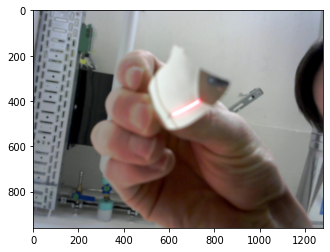

In [2]:
img = plt.imread('beacon.jpg',1)
plt.imshow(img, cmap = 'gray', vmin=0, vmax=255, interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### Mask region of no interest

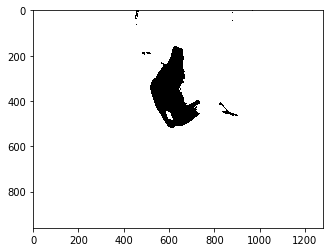

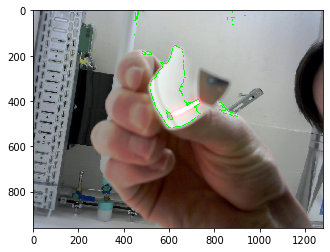

In [3]:
# convert to grayscale
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
# create a binary thresholded image
_, binary = cv.threshold(gray, 210, 255, cv.THRESH_BINARY_INV)
# show it
plt.imshow(binary, cmap="gray")
plt.show()
# find the contours from the thresholded image
contours, hierarchy = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv.drawContours(img, contours, -1, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

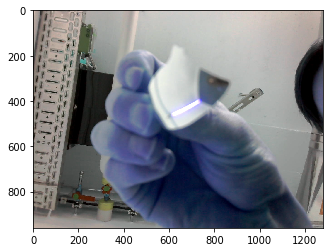

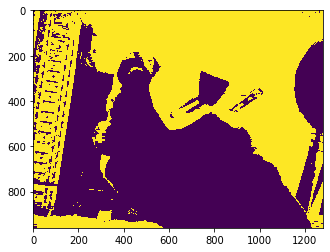

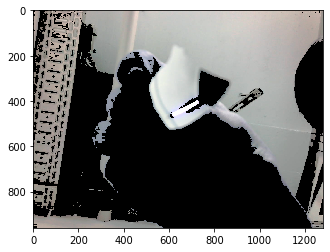

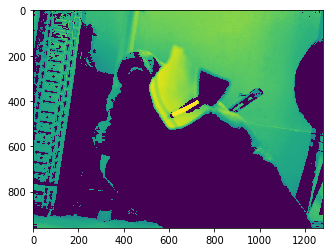

In [4]:
frame = cv.imread('beacon.jpg')
plt.imshow(frame)
plt.show()
hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
lower_blue = np.array([0, 0, 120])
upper_blue = np.array([180, 38, 255])
mask = cv.inRange(hsv, lower_blue, upper_blue)
result = cv.bitwise_and(frame, frame, mask=mask)
b, g, r = cv.split(result)  
filter = g.copy()
plt.imshow(mask)
plt.show()
plt.imshow(result)
plt.show()
plt.imshow(filter)
plt.show()

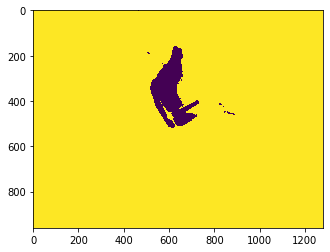

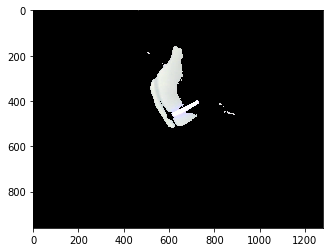

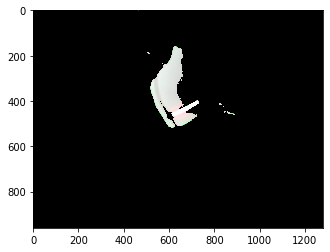

In [5]:
ret,mask = cv.threshold(filter,215,255, 1)
frame[mask == 255] = 0
plt.imshow(mask)
plt.show()
plt.imshow(frame)
plt.show()
mask_inv = cv.bitwise_not(mask)
result_mask = cv.bitwise_and(img, img, mask=mask_inv)
plt.imshow(result_mask)
plt.show()

In [2]:
class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "red": (255, 0, 0),
            "green": (0, 255, 0),
            "blue": (0, 0, 255)})
        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []
        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)
        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv.cvtColor(self.lab, cv.COLOR_RGB2LAB)


    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv.drawContours(mask, [c], -1, 255, -1)
        mask = cv.erode(mask, None, iterations=2)
        mean = cv.mean(image, mask=mask)[:3]
        # initialize the minimum distance found thus far
        minDist = (np.inf, None)
        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)
            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)
        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]

In [3]:
def detect(c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.04 * peri, True)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv.boundingRect(approx)
            ar = w / float(h) # aspect ration to distinguish if square ≈ 1 or rectangle 
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

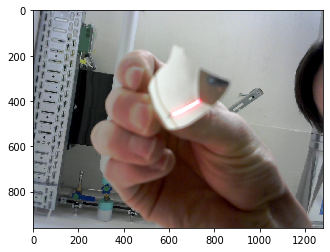

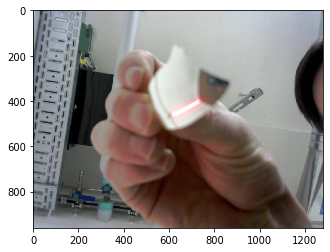

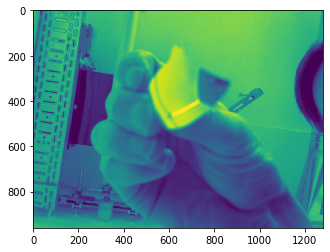

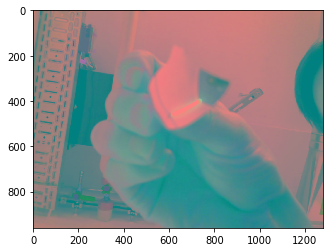

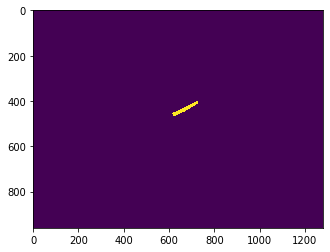

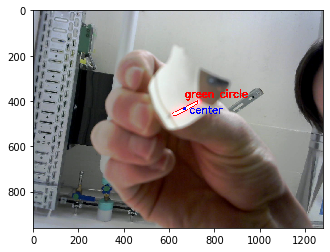

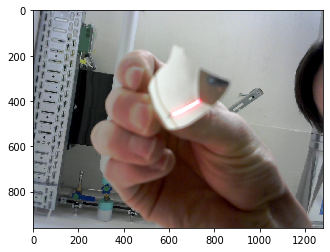

In [9]:
image = plt.imread('beacon.jpg')
plt.imshow(image)
plt.show()
# Masking




#resize image for faster computation
#resized = imutils.resize(image, width=300)
#ratio = image.shape[0] / float(resized.shape[0])

blurred = cv.GaussianBlur(image, (5,5), 0)
plt.imshow(blurred)
plt.show()
gray = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
plt.imshow(gray)
plt.show()
#blurred = cv.GaussianBlur(gray, (5,5), 0)
#plt.imshow(blurred)
#plt.show()
lab = cv.cvtColor(blurred, cv.COLOR_RGB2LAB)
plt.imshow(lab)
plt.show()
thresh = cv.threshold(gray, 250, 255, cv.THRESH_BINARY)[1]
plt.imshow(thresh)
plt.show()
# find contours in the thresholded image
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

cl = ColorLabeler()

# loop over the contours
for c in cnts:
    # compute the center of the contour
    M = cv.moments(c) # image moment
    if(M["m00"] > 50): 
        cX = int(M["m10"] / M["m00"]) #* ratio)
        cY = int(M["m01"] / M["m00"]) #* ratio)
        shape = detect(c)
        color = cl.label(lab, c)
        
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape and labeled
        # color on the image
        #c = c.astype("float")
        #c *= ratio
        #c = c.astype("int")
        text = "{} {}".format(color, shape)
        # draw the contour and center of the shape on the image
        cv.drawContours(image, [c], -1, (255, 0, 0), 2)
        cv.putText(image, text, (cX, cY - 50) ,cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 5)
        #cv.putText(image, shape, (cX, cY - 50) ,cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 5)
        cv.circle(image, (cX, cY), 7,  (0, 0, 255), -1)
        cv.putText(image, "center", (cX + 20, cY + 20),cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
plt.imshow(image)
plt.show()
img = plt.imread('beacon.jpg')
plt.imshow(img)
plt.show()


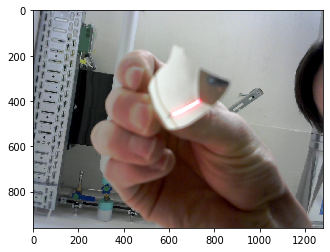

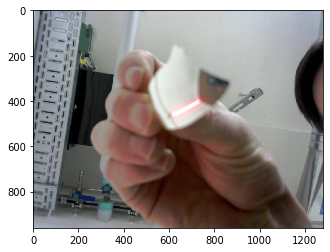

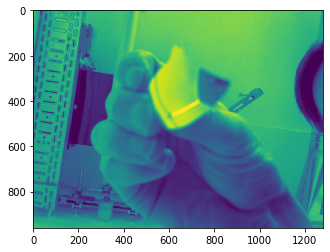

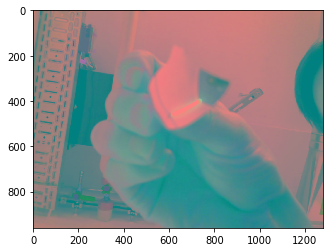

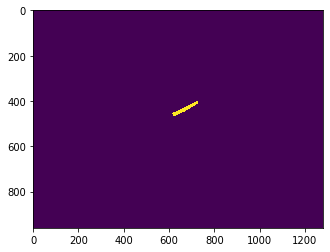

red


In [10]:
img = plt.imread('beacon.jpg')
plt.imshow(img)
plt.show()
blurred = cv.GaussianBlur(img, (5, 5), 0)
plt.imshow(blurred)
plt.show()
gray = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
plt.imshow(gray)
plt.show()
lab = cv.cvtColor(blurred, cv.COLOR_RGB2LAB)
plt.imshow(lab)
plt.show()
thresh = cv.threshold(gray, 250, 255, cv.THRESH_BINARY)[1]
plt.imshow(thresh)
plt.show()
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cl = ColorLabeler()
for c in cnts:
    color = cl.label(img, c)
    print(color)

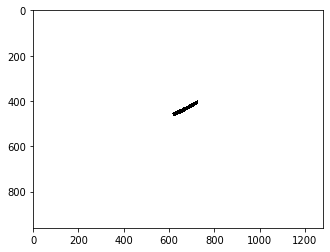

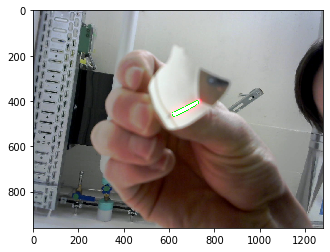

In [11]:
result = cv.imread('beacon.jpg')
# convert to RGB
img2 = cv.cvtColor(result, cv.COLOR_BGR2RGB)
# convert to grayscale
gray2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)
# create a binary thresholded image
_, binary2 = cv.threshold(gray2, 245, 255, cv.THRESH_BINARY_INV)
# show it
plt.imshow(binary2, cmap="gray")
plt.show()
# find the contours from the thresholded image
contours, hierarchy = cv.findContours(binary2, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv.drawContours(img2, contours, -1, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

### Mask region of no interest

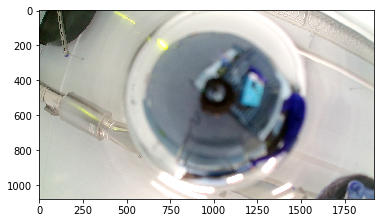

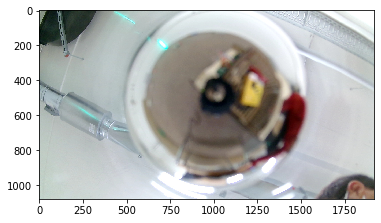

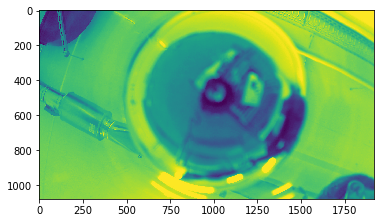

[[[1013.24994  490.34998  522.39   ]]]


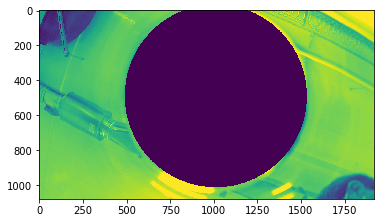

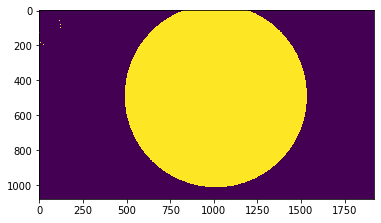

mask


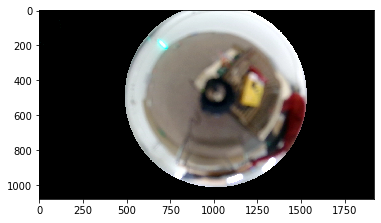

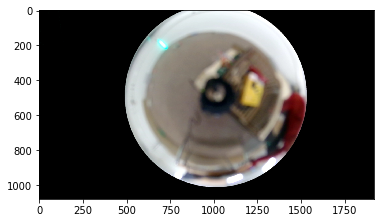

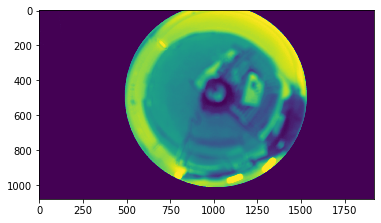

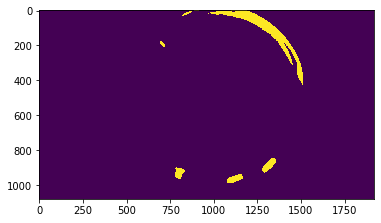

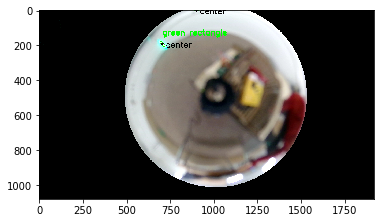

In [5]:
# load image BGR
img_BGR = cv.imread('greenBeacon.jpg')  
output = img_BGR.copy()
plt.imshow(img_BGR)
plt.show()
# load image RGB
img = plt.imread('greenBeacon.jpg')
#output = img.copy()
plt.imshow(img)
plt.show()
# convert to grayscale
gray = cv.cvtColor(img_BGR, cv.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

# detect circles 
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 2.1, 500, minRadius = 300, maxRadius = 700)
print(circles)
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (xc, yc, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv.circle(gray, (xc, yc), r, (0, 255, 0), -1)
        cv.rectangle(gray, (xc - 5, yc - 5), (xc + 5, yc + 5), (0, 128, 255), -1)
    # show the output image
    plt.imshow(gray)
    plt.show()

#b, g, r = cv.split(gray)  
#filter = g.copy()
ret,mask = cv.threshold(gray,10,255, 1)
#thresh = cv.threshold(filter, 230, 255, cv.THRESH_BINARY)[1]
plt.imshow(mask)
plt.show() 
print("mask")
#output[mask == 0] = 0
#plt.imshow(mask)
#plt.show()
#mask_inv = cv.bitwise_not(mask)
#plt.imshow(mask_inv)
#plt.show()
result_mask = cv.bitwise_and(img, img, mask=mask)
plt.imshow(result_mask)
plt.show()    


blurred = cv.GaussianBlur(result_mask, (5,5), 0)
plt.imshow(blurred)
plt.show()
gray_result = cv.cvtColor(blurred, cv.COLOR_RGB2GRAY)
plt.imshow(gray_result)
plt.show()
#blurred = cv.GaussianBlur(gray, (5,5), 0)
#plt.imshow(blurred)
#plt.show()
lab = cv.cvtColor(blurred, cv.COLOR_RGB2LAB)
#plt.imshow(lab)
#plt.show()
thresh = cv.threshold(gray_result, 245, 255, cv.THRESH_BINARY)[1]
plt.imshow(thresh)
plt.show()
# find contours in the thresholded image
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

cl = ColorLabeler()

# loop over the contours
for c in cnts:
    # compute the center of the contour
    M = cv.moments(c) # image moment
    if(M["m00"] > 50 and M["m00"] < 500): 
        cX = int(M["m10"] / M["m00"]) #* ratio)
        cY = int(M["m01"] / M["m00"]) #* ratio)
        shape = detect(c)
        color = cl.label(lab, c)
        
        if(color == 'red'):
            clr = [255, 0, 0]
        elif(color == 'green'):
            clr = [0, 255, 0]
        elif(color == 'blue'):
            clr = [0, 0, 255]
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape and labeled
        # color on the image
        #c = c.astype("float")
        #c *= ratio
        #c = c.astype("int")
        text = "{} {}".format(color, shape)
        # draw the contour and center of the shape on the image
        cv.drawContours(result_mask, [c], -1, clr, 2)
        cv.putText(result_mask, text, (cX, cY - 50) ,cv.FONT_HERSHEY_SIMPLEX, 1.5, clr, 5)
        #cv.putText(image, shape, (cX, cY - 50) ,cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 5)
        cv.circle(result_mask, (cX, cY), 7,  (0, 0, 0), -1)
        cv.putText(result_mask, "center", (cX + 20, cY + 20),cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3)
plt.imshow(result_mask)
plt.show()


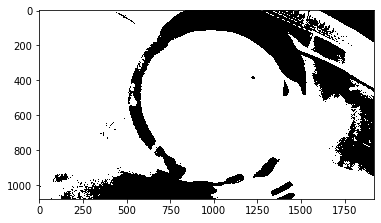

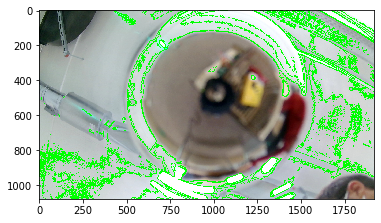

In [40]:
# create a binary thresholded image
_,binary = cv.threshold(gray, 210, 255, cv.THRESH_BINARY_INV)
plt.imshow(binary, cmap="gray")
plt.show()
# find the contours from the thresholded image
contours, hierarchy = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv.drawContours(img, contours, -1, (0, 255, 0), 2)
plt.imshow(image)
plt.show()